## Titanic Prediction


### Cleaning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import statsmodels.api as sm

# Section 1: Cleaning the Data
# Load the datasets
gender_submission = pd.read_csv('gender_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

# Extract title from the Name column before dropping it
combined = pd.concat([train, test], sort=False)
combined['Title'] = combined['Name'].str.extract(r' ([A-Za-z]+)\.')

# Define a mapping for titles
title_reduction = {
    'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss', 
    'Master': 'Master', 'Don': 'Mr', 'Rev': 'Rev',
    'Dr': 'Dr', 'Mme': 'Miss', 'Ms': 'Miss',
    'Major': 'Mr', 'Lady': 'Mrs', 'Sir': 'Mr',
    'Mlle': 'Miss', 'Col': 'Mr', 'Capt': 'Mr',
    'Countess': 'Mrs', 'Jonkheer': 'Mr',
    'Dona': 'Mrs'
}

# Apply title reduction
combined['Title'] = combined['Title'].map(title_reduction)

# Fill missing Age values based on median age by Title
for title, age in combined.groupby('Title')['Age'].median().items():
    combined.loc[(combined['Title'] == title) & (combined['Age'].isnull()), 'Age'] = age

# Now drop unnecessary columns
columns_to_drop = ['Cabin', 'Ticket', 'Name']
combined = combined.drop(columns=columns_to_drop, errors='ignore')

# Split the data back into train and test sets
train_cleaned = combined.loc[combined['PassengerId'].isin(train['PassengerId'])].copy()
test_cleaned = combined.loc[combined['PassengerId'].isin(test['PassengerId'])].copy()

# Handle other missing values
train_cleaned['Embarked'].fillna(train_cleaned['Embarked'].mode()[0], inplace=True)
test_cleaned['Embarked'].fillna(test_cleaned['Embarked'].mode()[0], inplace=True)
train_cleaned['Fare'].fillna(train_cleaned['Fare'].median(), inplace=True)
test_cleaned['Fare'].fillna(test_cleaned['Fare'].median(), inplace=True)

# Convert categorical variables to numerical
train_cleaned = pd.get_dummies(train_cleaned, columns=['Sex', 'Embarked', 'Title'], drop_first=True)
test_cleaned = pd.get_dummies(test_cleaned, columns=['Sex', 'Embarked', 'Title'], drop_first=True)

# Ensure both train and test datasets have the same columns
missing_cols = set(train_cleaned.columns) - set(test_cleaned.columns)
for col in missing_cols:
    if col != 'Survived':
        test_cleaned[col] = 0

# Reorder test columns to match train columns (excluding 'Survived')
test_cleaned = test_cleaned[train_cleaned.columns.drop('Survived')]

# Save cleaned datasets
train_cleaned.to_csv('cleaned_train.csv', index=False)
test_cleaned.to_csv('cleaned_test.csv', index=False)

# Display a few first rows of cleaned data
print("\nFirst few rows of cleaned training data:")
print(train_cleaned.head())
print("\nFirst few rows of cleaned test data:")
print(test_cleaned.head())


First few rows of cleaned training data:
   PassengerId  Survived  Pclass   Age  SibSp  Parch     Fare  Sex_male  \
0            1       0.0       3  22.0      1      0   7.2500      True   
1            2       1.0       1  38.0      1      0  71.2833     False   
2            3       1.0       3  26.0      0      0   7.9250     False   
3            4       1.0       1  35.0      1      0  53.1000     False   
4            5       0.0       3  35.0      0      0   8.0500      True   

   Embarked_Q  Embarked_S  Title_Master  Title_Miss  Title_Mr  Title_Mrs  \
0       False        True         False       False      True      False   
1       False       False         False       False     False       True   
2       False        True         False        True     False      False   
3       False        True         False       False     False       True   
4       False        True         False       False      True      False   

   Title_Rev  
0      False  
1      False  
2    

C:\Users\yosak\AppData\Local\Temp\ipykernel_19292\1975720826.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_cleaned['Embarked'].fillna(train_cleaned['Embarked'].mode()[0], inplace=True)
C:\Users\yosak\AppData\Local\Temp\ipykernel_19292\1975720826.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

### Train/Test

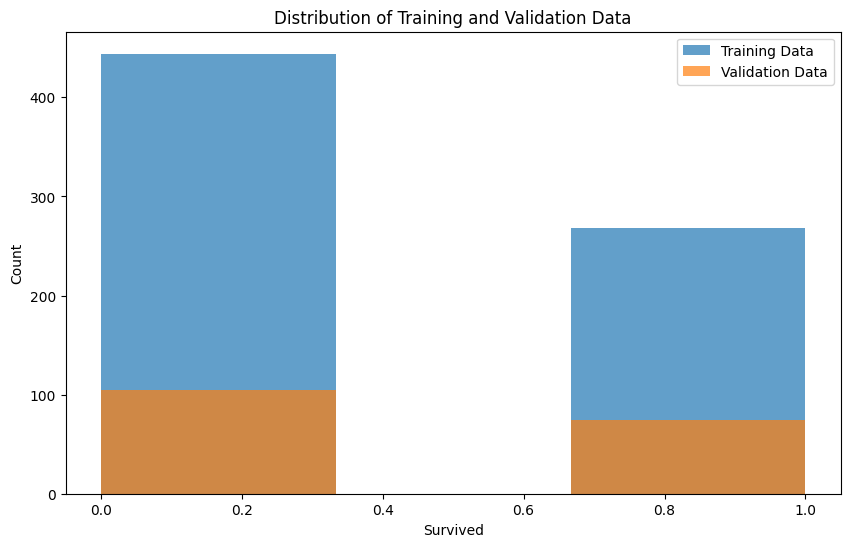

In [19]:
# Section 2: Train/Test the Data
# Use cleaned data for training
X = train_cleaned.drop('Survived', axis=1).values.astype(np.float64)
y = train_cleaned['Survived'].values.astype(np.float64)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot the training and validation data distribution
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=3, alpha=0.7, label='Training Data')
plt.hist(y_val, bins=3, alpha=0.7, label='Validation Data')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.title('Distribution of Training and Validation Data')
plt.legend()
plt.show()


### Modelling

In [20]:
# Section 3: Modelling using Linear Regression, Gradient Descent, and Neural Network
# Linear Regression using Statsmodels
X_train_sm = sm.add_constant(X_train)
X_val_sm = sm.add_constant(X_val)
linear_model = sm.OLS(y_train, X_train_sm).fit()
print(linear_model.summary())

# Predict using linear regression model
y_pred_val_lr = linear_model.predict(X_val_sm)
y_pred_class_lr = np.array([1 if i > 0.5 else 0 for i in y_pred_val_lr])

# Train a logistic regression model using gradient descent
# Initialize parameters
n_features = X_train.shape[1]
weights = np.zeros(n_features, dtype=np.float64)
bias = 0.0
learning_rate = 0.01
n_iterations = 10000

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-np.array(z, dtype=np.float64)))

# Training the model using gradient descent
for i in range(n_iterations):
    # Linear model
    linear_model_gd = np.dot(X_train, weights) + bias
    # Prediction
    y_predicted = sigmoid(linear_model_gd)
    
    # Compute gradients
    dw = (1 / len(y_train)) * np.dot(X_train.T, (y_predicted - y_train))
    db = (1 / len(y_train)) * np.sum(y_predicted - y_train)
    
    # Debugging prints
    if i % 1000 == 0:
        print(f"Iteration {i}: weights shape: {weights.shape}, dw shape: {dw.shape}, bias: {bias}, db: {db}")

    # Update parameters
    weights -= learning_rate * dw
    bias -= learning_rate * db

# Train a simple neural network model using TensorFlow
model = Sequential()
model.add(Dense(200, input_dim=n_features, activation='sigmoid'))
model.add(Dense(200, activation='sigmoid'))
model.add(Dense(200, activation='sigmoid'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train.astype(np.float32), y_train.astype(np.float32), epochs=1750, batch_size=64, validation_data=(X_val.astype(np.float32), y_val.astype(np.float32)))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     41.88
Date:                Wed, 30 Oct 2024   Prob (F-statistic):           1.55e-78
Time:                        15:09:02   Log-Likelihood:                -289.04
No. Observations:                 712   AIC:                             606.1
Df Residuals:                     698   BIC:                             670.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7686      0.076     10.058      0.0

C:\Users\yosak\AppData\Local\Temp\ipykernel_19292\2448178494.py:22: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-np.array(z, dtype=np.float64)))


Iteration 2000: weights shape: (14,), dw shape: (14,), bias: -0.1478508307826151, db: -0.34602057784338774
Iteration 3000: weights shape: (14,), dw shape: (14,), bias: -0.16259280560505932, db: -0.2107374492259594
Iteration 4000: weights shape: (14,), dw shape: (14,), bias: -0.17202314902095064, db: 0.5380937016819616
Iteration 5000: weights shape: (14,), dw shape: (14,), bias: -0.18309507147060672, db: -0.34765603400161543
Iteration 6000: weights shape: (14,), dw shape: (14,), bias: -0.17996989315617645, db: -0.2148467102718893
Iteration 7000: weights shape: (14,), dw shape: (14,), bias: -0.17306322949756506, db: 0.5351912638567138
Iteration 8000: weights shape: (14,), dw shape: (14,), bias: -0.16507416605273287, db: -0.3468309361497545
Iteration 9000: weights shape: (14,), dw shape: (14,), bias: -0.1436783054279767, db: -0.22414670815514473
Epoch 1/1750


c:\Users\yosak\anaconda3\envs\se411_Final_Project\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3033 - mae: 0.4878 - val_loss: 0.2364 - val_mae: 0.4806
Epoch 2/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2404 - mae: 0.4776 - val_loss: 0.2301 - val_mae: 0.4762
Epoch 3/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2314 - mae: 0.4648 - val_loss: 0.2189 - val_mae: 0.4628
Epoch 4/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2229 - mae: 0.4447 - val_loss: 0.2035 - val_mae: 0.4365
Epoch 5/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2094 - mae: 0.4312 - val_loss: 0.1950 - val_mae: 0.4115
Epoch 6/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2131 - mae: 0.4272 - val_loss: 0.1868 - val_mae: 0.3968
Epoch 7/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2055 - mae: 0.3955 - val_loss: 0.1902 - val_mae: 0.3863
Epoch 8/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1978 - mae: 0.3974 - val_loss: 0.1938 - val_mae: 0.4197
Epoch 9/1750
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2152 -

### Prediction

In [22]:
# Section 4: Prediction
# Make predictions on the validation set using gradient descent model
linear_model_val = np.dot(X_val, weights) + bias
y_pred_val_gd = sigmoid(linear_model_val)
y_pred_class_gd = np.array([1 if i > 0.5 else 0 for i in y_pred_val_gd])

# Make predictions on the validation set using neural network model
y_pred_nn_val = model.predict(X_val.astype(np.float32)).flatten()
y_pred_nn_class = np.array([1 if i > 0.5 else 0 for i in y_pred_nn_val])

# Make predictions on the test set using gradient descent model
linear_model_test = np.dot(test_cleaned.values, weights) + bias
y_pred_test_gd = sigmoid(linear_model_test)
test_predictions_gd = np.array([1 if i > 0.5 else 0 for i in y_pred_test_gd])

# Make predictions on the test set using neural network model
y_pred_nn_test = model.predict(test_cleaned.values.astype(np.float32)).flatten()
test_predictions_nn = np.array([1 if i > 0.5 else 0 for i in y_pred_nn_test])

# Save predictions
gender_submission['Survived'] = test_predictions_nn
gender_submission.to_csv('submission.csv', index=False)

print("\nTraining, testing, and prediction complete. Predictions saved to '/mnt/data/'")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Training, testing, and prediction complete. Predictions saved to '/mnt/data/'


### Evaluvation


Linear Regression R-squared on validation set: 0.4469379301512585


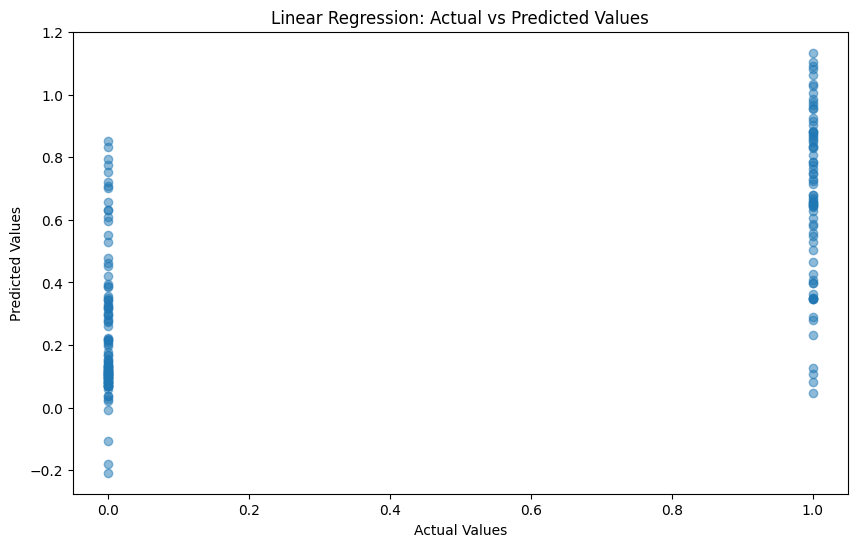


Logistic Regression Accuracy on validation set: 0.44692737430167595

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.09      0.15       105
         1.0       0.43      0.96      0.59        74

    accuracy                           0.45       179
   macro avg       0.59      0.52      0.37       179
weighted avg       0.62      0.45      0.33       179


Confusion Matrix:
[[ 9 96]
 [ 3 71]]


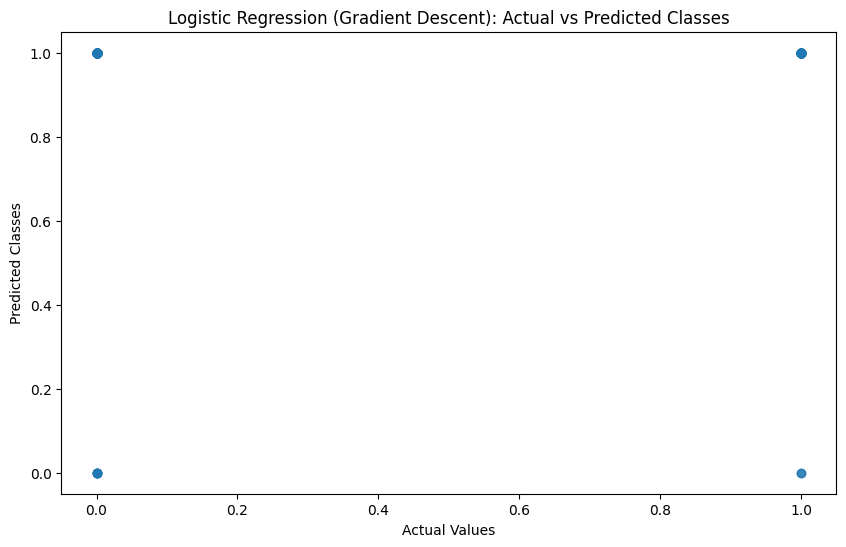


Neural Network Accuracy on validation set: 0.7653631284916201

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.78      0.80       105
         1.0       0.71      0.74      0.72        74

    accuracy                           0.77       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179


Confusion Matrix:
[[82 23]
 [19 55]]


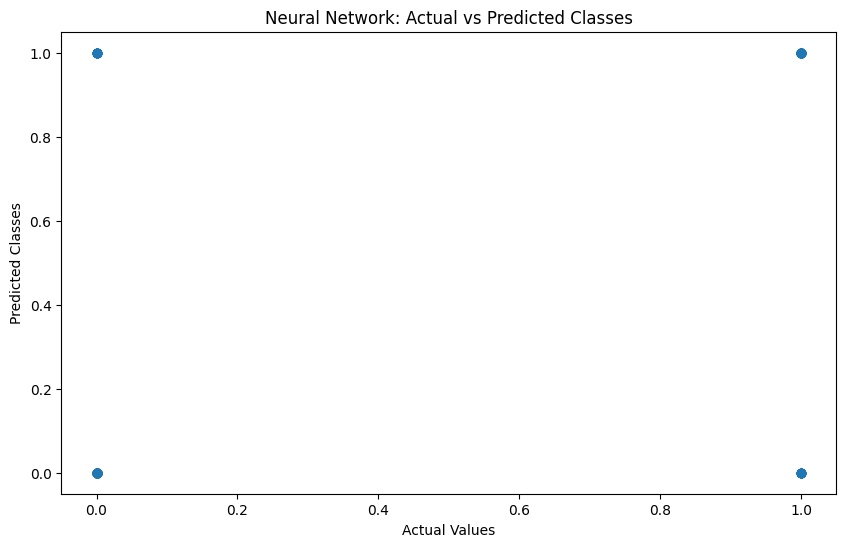

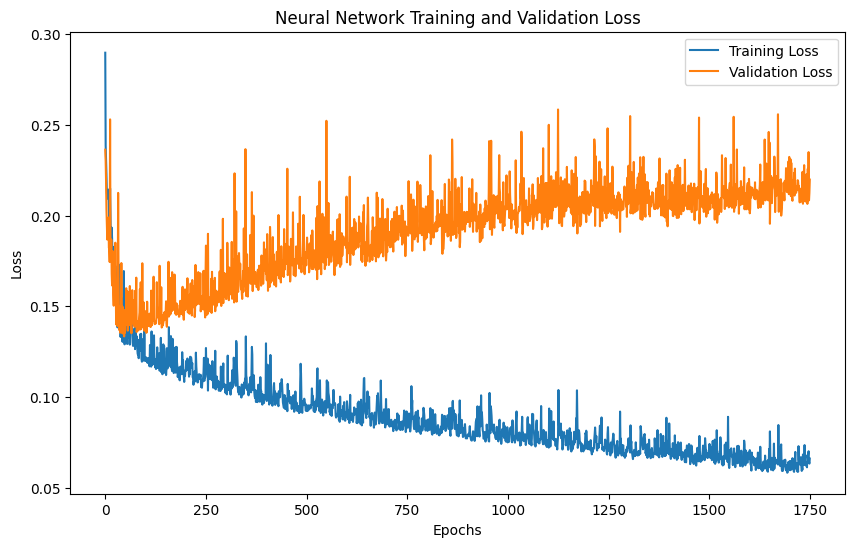

In [23]:
# Section 5: Evaluation
# Ensure predictions are in the correct format
y_pred_class_lr = np.array(y_pred_class_lr).flatten()
y_pred_class_gd = np.array(y_pred_class_gd).flatten()
y_pred_nn_class = np.array(y_pred_nn_class).flatten()
y_val = y_val.flatten()

# Evaluate the linear regression model
y_pred_val_lr = y_pred_val_lr.flatten()
r2 = r2_score(y_val, y_pred_val_lr)
print("\nLinear Regression R-squared on validation set:", r2)

# Plot the linear regression results
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val_lr, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression: Actual vs Predicted Values')
plt.show()

# Evaluate the gradient descent model
accuracy_gd = accuracy_score(y_val, y_pred_class_gd)
print("\nLogistic Regression Accuracy on validation set:", accuracy_gd)
print("\nClassification Report:")
print(classification_report(y_val, y_pred_class_gd))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_class_gd))

# Plot the gradient descent results
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_class_gd, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Classes')
plt.title('Logistic Regression (Gradient Descent): Actual vs Predicted Classes')
plt.show()

# Evaluate the neural network model
nn_accuracy = accuracy_score(y_val, y_pred_nn_class)
print("\nNeural Network Accuracy on validation set:", nn_accuracy)
print("\nClassification Report:")
print(classification_report(y_val, y_pred_nn_class))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_nn_class))

# Plot the neural network results
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_nn_class, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Classes')
plt.title('Neural Network: Actual vs Predicted Classes')
plt.show()

# Plot training and validation losses for neural network
if 'loss' in history.history and 'val_loss' in history.history:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Neural Network Training and Validation Loss')
    plt.legend()
    plt.show()
else:
    print("The history object does not contain 'loss' or 'val_loss' keys.")